# Classification of b-quark jets in the Aleph simulated data

The following is an introduction to using Machine Learning (ML) - in particular Boosted Decision Trees (BDT) - for trying to determine, if an entry in a data file is of one type (signal, ill, guilty, etc.) or another (background, healthy, innocent, etc.).

You may choose between two data samples:
1. A particle physics dataset containing simulated decays of the $Z^0$ boson decaying to a quark and an anti-quark producing two "jets" of particles. The question is, if the jets are from a b-quark (b-jet) or from lighter quarks (l-jet).
3. A "medical" dataset which concers a lifestyle disease in relation to various (transformed) lifestyle variables (reduced in number of variables to match the Aleph b-jet data set).

In the following, we discuss the problem from the b-jet point of view, as this is where the largest size datasets are available. However, we stress that from the point of view of ML, data content (what is being considered) is not essential to know (for now!!!). And knowing the content in details requires domain knowledge, i.e. that you are an expert in the specific field, that the data comes from. This part is very important, but not the focus in this course.

In the end, this exercise is the simple start "outside ML" and moving into the territory of Machine Learning analysis.

### The Data:
The input variables (X) are (used by Aleph for their NN):
* **prob_b**: Probability of being a b-jet from the pointing of the tracks to the vertex.
* **spheri**: Sphericity of the event, i.e. how spherical it is.
* **pt2rel**: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* **multip**: Multiplicity of the jet (in a relative measure).
* **bqvjet**: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* **ptlrel**: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).

Auxilary variables (Z) are (not used by Aleph for their NN):
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the Aleph detector was essentially uniform in phi, this should not matter (much).

The target variable (Y) is:
* **isb**:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net (6 input variables, two hidden layers with 10 neurons in each, and 1 output varible) based classification variable, which you can compare to (and compete with?):
* **nnbjet**: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).

In case you choose **the medical data**, the variables to use as input (X) are: **Qsocial, BMI, Roccupat, Rgenetic, Rdietary, and Rhormonn** (reflecting Quantiles and Ratios of medical measurements). The target variable (Y) is (naturally): **TrulyIll**, and you can compare your results to the average of doctors: **DocScore**.


### The Task:
Thus, the task before you is to produce functions (non-ML and ML algorithm), which given the input variables X provides an output variable estimate, Y_est, which is "closest possible" to the target variable, Y. The "closest possible" is left to the user to define in a _Loss Function_, which we will discuss further later. In classification problems (such as this), the typical loss function to use is ["Cross Entropy"](https://en.wikipedia.org/wiki/Cross_entropy).

You should approach the problem in two ways:
* Initially (i.e. first 15-30 minutes), simply with "if"-statements making requirements on certain variables. This corresponds to selecting "boxes" in the input variable space (typically called "X"). One could also try a linear combination of input variables (i.e. a Fisher discriminant), which corresponds to a plane in the X-space. Such a solution is fast and transparent (very good), but as the data contains non-linear correlations, it is likely to approximate.<br>
**The point of this step is NOT to make a great algorith, but rather to set up comparing different algorithms!**

* Next using Machine Learning (ML) methods. We will during the first week try both Boosted Decision Tree (BDT) based and Neural Net (NN) based methods, and see how complicated (or not) it is to get a good solution, and how much better it performs compared to the "classic" selection method.

Once you obtain a classification of b-jets vs. non-b-jets, think about how to quantify the quality of your algorithm. Once you have a "metric" for doing so, try to compare it to the NN result of the Aleph collaboration, given by the variable "nnbjet". It is based on a neural network with 6 input variables (prob_b, spheri, pt2rel, multip, bqvjet, and ptlrel), and two hidden layers each with 10 nodes in. Can you do better?

Don't hold back in drawing inspiration from "ML_MethodsDemos.ipynb" (in Week0) or the vast internet. BDT suggestions might be [XGBoost](https://xgboost.readthedocs.io/en/release_3.0.0/) or [LightGBM](https://lightgbm.readthedocs.io/en/stable/). NN suggestions might be [PyTorch](https://pytorch.org/) or [TensorFlow](https://www.tensorflow.org/).

* Author: Troels C. Petersen (NBI)
* Email:  petersen@nbi.dk
* Date:   15th of April 2025

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
import pandas as pd 
from pandas import Series, DataFrame 
from matplotlib import pyplot as plt
import numpy as np

SavePlots = False

## Import and inspect the data:

In [4]:
# Read the data and print the variables:
import os

# Set the working directory to the location of your script
#os.chdir('/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork')              # Coppied from mac path
os.chdir(r'C:\Users\Niels\GitHub\AppliedML2025_fork')                                     # Windows path    
current_dir = os.getcwd()                                                               # Get the current working directory                    
csv_path = os.path.join(current_dir, 'Week1', 'AlephBtag_MC_train_Nev5000.csv')         # Joining the path of CSV file
csv_path = os.path.normpath(csv_path)                                                   # Normalize the path to avoid issues with slashes

# Read the CSV file into a DataFrame
data = pd.DataFrame(np.genfromtxt(str(csv_path), names=True))                          

variables = data.columns
print(variables.values)

# Decide on which variables to use for input (X) and what defines the label (Y):
input_variables = variables[(variables != 'nnbjet') & (variables != 'isb') & (variables != 'energy') & (variables != 'cTheta') & (variables != 'phi')]
input_data      = data[input_variables]
truth_data      = data['isb']
benchmark_data  = data['nnbjet']
print("  Variables used for training: ", input_variables.values)

['energy' 'cTheta' 'phi' 'prob_b' 'spheri' 'pt2rel' 'multip' 'bqvjet'
 'ptlrel' 'nnbjet' 'isb']
  Variables used for training:  ['prob_b' 'spheri' 'pt2rel' 'multip' 'bqvjet' 'ptlrel']


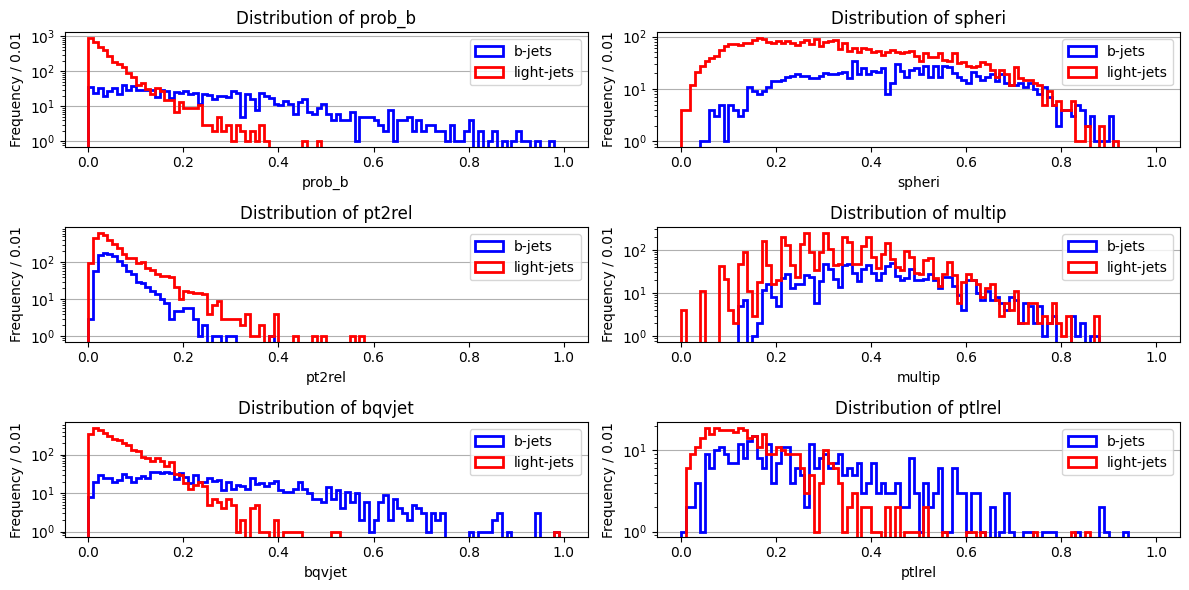

In [5]:
# Look at the distribution of the input variables for each event type:
mask = (data['isb'] == 1)      # Mask to divide the event types

fig, ax = plt.subplots(3,2,figsize=(12, 6), dpi=100)

for i, var in enumerate(input_variables):
    ax[i//2, i%2].hist(data[var][mask], bins=100, range=(0.0, 1.0), histtype='step', linewidth=2, label='b-jets', color='blue')
    ax[i//2, i%2].hist(data[var][~mask], bins=100, range=(0.0, 1.0), histtype='step', linewidth=2, label='light-jets', color='red')
    ax[i//2, i%2].set_xlabel(var)
    ax[i//2, i%2].set_ylabel("Frequency / 0.01")
    ax[i//2, i%2].set_title(f"Distribution of {var}")
    ax[i//2, i%2].legend(loc='best')
    ax[i//2, i%2].set_yscale("log")
    ax[i//2, i%2].grid(axis='y')
fig.tight_layout()

if SavePlots :
    fig.savefig('Hist_prob_b.pdf', dpi=600)

## Selection:

Imagine that you had never heard of Machine Learning (ML), and had to select b-jets without! This would probably boil down to doing so simply based on "if"-sentences, as shown below: 

In [6]:
# Give the variables logic names, and define them early, so that they only need to be changed
# in ONE place (also to ensures consistency!):
cut_prop_b  = 0.15

# If prob_b indicate b-quark, call it a b-quark, otherwise not! You can expand on this yourself at will.
bquark=[]
for i in np.arange(len(data['prob_b'])):
    if (data['prob_b'][i] > cut_prop_b) : bquark.append(1)
    else : bquark.append(0)

## Evaluate the selection:

In [7]:
def evaluate(bquark) :
    N = [[0,0], [0,0]]   # Make a list of lists (i.e. confusion matrix) for counting successes/failures.
    for i in np.arange(len(data['isb'])):
        if (bquark[i] == 0 and data['isb'][i] == 0) : N[0][0] += 1
        if (bquark[i] == 0 and data['isb'][i] == 1) : N[0][1] += 1
        if (bquark[i] == 1 and data['isb'][i] == 0) : N[1][0] += 1
        if (bquark[i] == 1 and data['isb'][i] == 1) : N[1][1] += 1
    fracWrong = float(N[0][1]+N[1][0])/float(len(data['isb']))
    accuracy = 1.0 - fracWrong
    return N, accuracy, fracWrong


RESULT OF HUMAN ATTEMPT AT A SELECTION:
  First number in parenthesis is the estimate, second is the MC truth (i.e. label):
  True-Negative (0,0)  =  3673
  False-Negative (0,1) =  443
  False-Positive (1,0) =  149
  True-Positive (1,1)  =  735
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.1184
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.8815999999999999


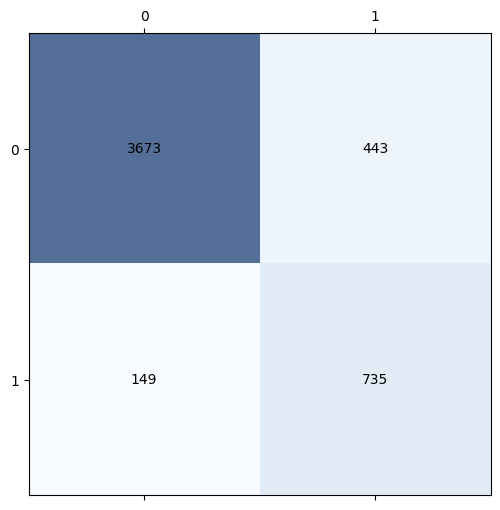

In [8]:
N, accuracy, fracWrong = evaluate(bquark)
print("\nRESULT OF HUMAN ATTEMPT AT A SELECTION:")
print("  First number in parenthesis is the estimate, second is the MC truth (i.e. label):")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)
# Make a plot of the confusion matrix, and add numbers in each tile:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.matshow(N, cmap=plt.cm.Blues, alpha=0.7)
for (i, j), z in np.ndenumerate(N):
    ax.text(j, i, str(z), ha='center', va='center', color='k')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])


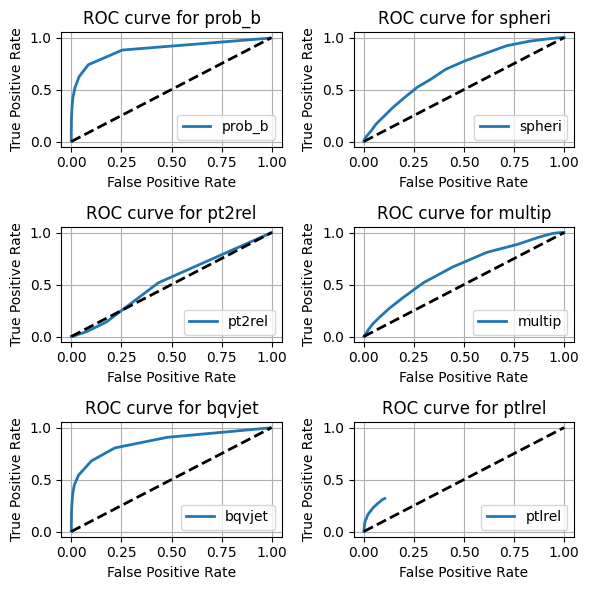

In [10]:
# Constrcuting ROC curves
x_range = np.arange(0.0, 1.05, 0.05)

tp_var = []
fp_var = []
for var in input_variables:
    tp_values = []
    fp_values = []
    for cut in x_range:
        bquark=[]
        for i in np.arange(len(data[var])):
            if (data[var][i] > cut) : bquark.append(1)
            else : bquark.append(0)
        N, accuracy, fracWrong = evaluate(bquark)
        tp_values.append(float(N[1][1])/float(N[1][1]+N[0][1]))  # True Positive Rate
        fp_values.append(float(N[1][0])/float(N[1][0]+N[0][0]))  # False Positive Rate

    tp_var.append(tp_values)
    fp_var.append(fp_values)

fig, ax = plt.subplots(3,2, figsize=(6, 6), dpi=100)
for i, var in enumerate(input_variables):
    ax[i//2, i%2].plot(fp_var[i], tp_var[i], label=var, linewidth=2)
    ax[i//2, i%2].set_xlabel("False Positive Rate")
    ax[i//2, i%2].set_ylabel("True Positive Rate")
    ax[i//2, i%2].set_title(f"ROC curve for {var}")
    ax[i//2, i%2].legend(loc='lower right')
    ax[i//2, i%2].grid()
    ax[i//2, i%2].plot([0, 1], [0, 1], 'k--', linewidth=2)  # Diagonal line
#fig.sup_title("ROC curves for different variables", fontsize=16)
fig.tight_layout()

In [11]:
# Compare with Aleph NN-approach from 1990'ies (choosing a reasonable selection cut on "nnbjet"):
bquark=[]
for i in np.arange(len(data['nnbjet'])):
    if   (data['nnbjet'][i] > 0.82) : bquark.append(1)
    else : bquark.append(0)

N, accuracy, fracWrong = evaluate(bquark)
print("\nALEPH BJET TAG:")
print("  First number in parenthesis is the estimate, second is the MC truth (i.e. label):")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)


ALEPH BJET TAG:
  First number in parenthesis is the estimate, second is the MC truth (i.e. label):
  True-Negative (0,0)  =  3700
  False-Negative (0,1) =  372
  False-Positive (1,0) =  122
  True-Positive (1,1)  =  806
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.0988
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.9012


## Boosted Decision Trees (BDT): CONTINUE HERE!!!
Construct a BDT to classify the b-jets. The BDT is a supervised ML algorithm, which means that it requires a training set of data with known labels (i.e. b-jet or not). The BDT will learn to classify the data based on the input variables (X) and the target variable (Y).



In [33]:

# XGBoost
import xgboost as xgb

# LightGBM
import lightgbm as lgb

# Sklearn imports
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split


# Misc
import time


## LightGBM decision trees


In [34]:
start = time.time()

# Make a train/test split
X_train, X_test, y_train, y_test, bench_train, bench_test = train_test_split(input_data, truth_data, benchmark_data, test_size=0.2, random_state=42)

# Create a LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Set the parameters for LightGBM
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 6,
    'learning_rate': 0.1,
    'verbose': 0,
        }

# Train the model
lgb_model = lgb.train(
                        params, 
                        lgb_train, 
                        num_boost_round=100, 
                        valid_sets=lgb_test, 
                        callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True)]
                    )

# Make predictions
y_score = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred = np.where(y_score > 0.1, 1, 0)  # Convert probabilities to binary predictions

# Time it
end = time.time()
print("Time taken to train LightGBM model: ", round(end - start, 4), " seconds")

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.255911
Time taken to train LightGBM model:  0.047  seconds


AUC:  0.9410161280108083
Accuracy:  0.821


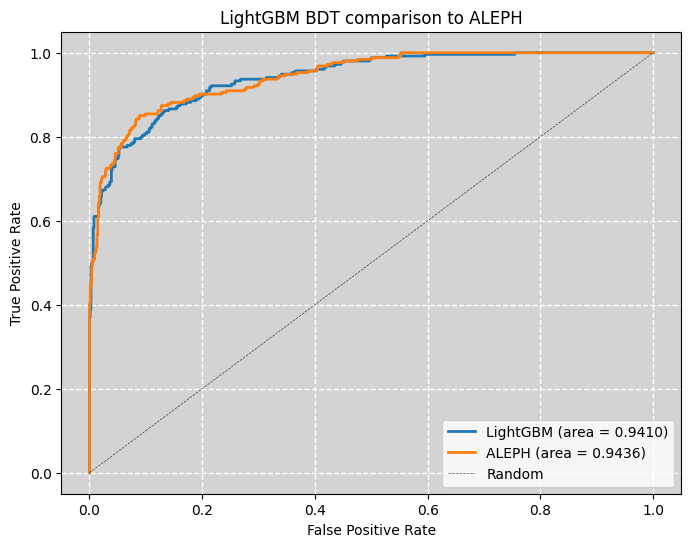

In [43]:
# Evaluate the model
fpr, tpr, _ = roc_curve(y_test, y_score)
fpr_aleph, tpr_aleph, _ = roc_curve(y_test, bench_test)
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)
print("Accuracy: ", accuracy_score(y_test, y_pred))

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='LightGBM (area = {:.4f})'.format(roc_auc), linewidth=2)
plt.plot(fpr_aleph, tpr_aleph, label='ALEPH (area = {:.4f})'.format(auc(fpr_aleph, tpr_aleph)), linewidth=2)
plt.plot()
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.5, alpha=0.7, label='Random')  # Diagonal line
plt.grid(color='white', linestyle='--', linewidth=1)
plt.gca().set_facecolor('lightgrey')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM BDT comparison to ALEPH')
plt.legend(loc='lower right')





## Questions:

1. Start by plotting the six "Aleph classification variables" and calculate their correlation matrices for signal and background, and see which seems to separate and correlate most (optional).

2. Above, the scoring is simply done by considering the fraction of wrong estimates. Think about what the alternatives could be, especially if you were to give a continuous score like the Aleph-NN. This scoring is called the "loss function".

3. <b>Draw ROC curves for each of these six separately, to quantify the separation. Also draw the Aleph-NN variable (nnbjet).</b> Is the Aleph-NN better? Are any of the variables "seemingly worthless"? (we will return to this point later).<br>
Note that decision variables (i.e. 0 and 1) yield a single point in the ROC curve plot.

5. <b>Try to get a BDT to make predictions based on the six given input variables. Plot the result in the ROC curve, and see if you managed to compete or even improve upon the Aleph-NN scores.</b>

6. <b>Think about what data you based your predictions on? Was it the same data that you trained the algorithm on? And if that is the case, is that reasonable?<b>

7. Does including more data (50000 instead of 5000 events) improve your performance?

8. Does including the kinematic variables 'energy', 'cTheta', and 'phi' (which are not related to jet type) improve your performance?

## Learning points:

From this exercise you should:

1. get a feel for the problem at hand, namely to separate two populations in a 6-dimensional space. It is hard to imagine, yet with simple cuts you should be able to get "some performance", though never close to the Aleph-NN.

2. learn, that it is hard to do "by hand", but that at least the fact that you have known cases (i.e. labels) makes you capable of getting some performance.

3. be able to draw ROC curves to compare performances between different variables and scores (floating or discrete).

4. know that you can (typically) improve the performance through the use of Machine Learning (ML).

5. <b>be capable not only of getting ML results, but also confident in optimising them, and certainly proficient in interpreting them.</b>